In [2]:
import re
import numpy as np
import seaborn as sns
import matplotlib
import math
import pandas as pd
import os


from matplotlib import pyplot as plt
from glob import glob
from dateutil.parser import parse as parse_date

import mpl_toolkits.mplot3d as a3
import seaborn as sns
import pickle

from scipy.spatial import ConvexHull
from scipy.spatial import HalfspaceIntersection
from matplotlib import pyplot as plt

sns.set_theme(font_scale=1.5)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams.update({'font.size': 15})

In [ ]:
!python main.py -d person -p 'smokes(person);friends(person,person)' \
    -f 'friends(x,y);smokes(x);friends(x,y) ^ smokes(x) => smokes(y)' -s 10

In [12]:
def parse_WFOMC_num(log_str):
    res = re.findall(r'num of call WFOMC: (\d+)', log_str)
    return int(res[0])

def parse_wfomc_time(log_str):
    res = re.findall(r'elapsed time for WFOMC call: ([\d\.]*)', log_str)
    return list(map(lambda x: float(x), res))

def parse_quick_hull_time(log_str):
    res = re.findall(r'elapsed time for quick-hull: ([\d\.]*)', log_str)
    return list(map(lambda x: float(x), res))

def parse_add_facet_time(log_str):
    res = re.findall(r'function add_facet execution time: ([\d\.]*)', log_str)
    return list(map(lambda x: float(x), res))

def parse_total_time(log_str):
    res = re.findall(r'Total time for finding convex hull: ([\d\.]*)', log_str)
    return float(res[0])

def parse_time(log_file):
    with open(log_file, 'r') as f:
        log = f.read()
    total_time, wfomc_time, quick_hull_time, add_facet_time = \
        parse_total_time(log), parse_wfomc_time(log), parse_quick_hull_time(log), parse_add_facet_time(log)
    WFOMC_num = parse_WFOMC_num(log)
    return total_time, WFOMC_num, wfomc_time, quick_hull_time, add_facet_time


def parse_convex_hull(file_name):
    with open(file_name, 'rb') as f:
        convex_hull = pickle.load(f)
    n_vertices = convex_hull.vertices.shape[0]
    n_facets = convex_hull.equations.shape[0]
    return n_vertices, n_facets
    

def plot(log_dir, prefix='2d', max_domain_size = 50):
    WFOMC_nums = []
    total_wfomc_time = []
    average_wfomc_time = []
    total_quick_hull_time = []
    average_quick_hull_time = []
    total_add_facet_time = []
    average_add_facet_time = []
    for i in range(1, max_domain_size + 1):
        _, WFOMC_num, wfomc_time, quick_hull_time, add_facet_time = parse_time('{}/{}/log.txt'.format(log_dir, i))
        total_wfomc_time.append(np.sum(wfomc_time))
        average_wfomc_time.append(np.mean(wfomc_time))
        total_quick_hull_time.append(np.sum(quick_hull_time))
        average_quick_hull_time.append(np.mean(quick_hull_time))
        total_add_facet_time.append(np.sum(add_facet_time))
        average_add_facet_time.append(np.mean(add_facet_time))
        WFOMC_nums.append(WFOMC_num)


    plt.title('Total WFOMC calls ({})'.format(prefix))
    WFOMC_nums = np.array(WFOMC_nums)
#     WFOMC_nums = np.log(WFOMC_nums)
    plt.plot(WFOMC_nums)
    plt.xlabel('domain size')
    plt.ylabel('call number')
    plt.show()


    plt.title('Total runtime for each part ({})'.format(prefix))
    colors = sns.color_palette('hls', 3)
    plt.plot(total_wfomc_time, label='wfomc', color=colors[0])
    plt.plot(total_quick_hull_time, label='quick hull', color=colors[1])
    # plt.plot(total_add_facet_time, label='convex hull processing', color=colors[2])
    plt.legend()
    plt.xlabel('domain size')
    plt.ylabel('second')
    plt.show()


    plt.title('Average runtime for each part ({})'.format(prefix))
    colors = sns.color_palette('hls', 3)
    plt.plot(average_wfomc_time, label='wfomc', color=colors[0])
    plt.plot(average_quick_hull_time, label='quick hull', color=colors[1])
    # plt.plot(average_add_facet_time, label='convex hull processing', color=colors[2])
    plt.legend()
    plt.xlabel('domain size')
    plt.ylabel('second')
    plt.show()

In [ ]:
plot('./logs/2d/iter/', '2d')
plot('./logs/2d/dft/', '2d', 11)

In [13]:
def parse_file(iter_dirs, dft_dirs, exp_names, max_domain_size):
    dataset = []
    for j, (iter_dir, dft_dir) in enumerate(zip(iter_dirs, dft_dirs)):
        for i in range(2, max_domain_size[j] + 1):
            iter_log = '{}/{}/log.txt'.format(iter_dir, i)
            iter_total_time, iter_wfomc_num, _, _, _ = parse_time(iter_log)
            iter_n_vertices, iter_n_facets = parse_convex_hull('{}/{}/convex_hull.pkl'.format(iter_dir, i))
            dft_log = '{}/{}/log.txt'.format(dft_dir, i)
            dft_total_time, dft_wfomc_num, _, _, _ = parse_time(dft_log)
            dft_n_vertices, dft_n_facets = parse_convex_hull('{}/{}/convex_hull.pkl'.format(dft_dir, i))
            dataset.append([exp_names[j], 'WFOMC calls', 
                            i, iter_wfomc_num, dft_wfomc_num])
            dataset.append([exp_names[j], 'Runtime', 
                            i, iter_total_time, dft_total_time])
            dataset.append([exp_names[j], 'Number of vertices', 
                           i, iter_n_vertices, dft_n_vertices])
            dataset.append([exp_names[j], 'Number of facets',
                           i, iter_n_facets, dft_n_facets])
    dataframe = pd.DataFrame(dataset)
    return dataframe
    

def plot_comparison(iter_dir, dft_dir, prefix='2d', max_domain_size=50):
    iter_wfomc_num = []
    dft_wfomc_num = []
    iter_time = []
    dft_time = []
    for i in range(2, max_domain_size + 1):
        iter_log = '{}/{}/log.txt'.format(iter_dir, i)
        dft_log = '{}/{}/log.txt'.format(dft_dir, i)
        total_time, wfomc_num, _, _, _ = parse_time(iter_log)
        iter_wfomc_num.append(wfomc_num)
        iter_time.append(total_time)
        total_time, wfomc_num, _, _, _ = parse_time(dft_log)
        dft_wfomc_num.append(wfomc_num)
        dft_time.append(total_time)
    
    domain_size = list(range(2, max_domain_size + 1))
    
    colors = sns.color_palette('hls', 4)
    
    fig, ax1 = plt.subplots()
    ax1.plot(domain_size, iter_wfomc_num, color=colors[0], linestyle='--', label='Iter wfomc number')
    ax1.plot(domain_size, dft_wfomc_num, color=colors[1], linestyle='--', label='DFT wfomc number')

    ax2 = ax1.twinx()
    ax2.plot(domain_size, iter_time, color=colors[0], label='Iter time')
    ax2.plot(domain_size, dft_time, color=colors[1], label='DFT time')

    ax1.set_xlabel('domain size')
    ax1.set_ylabel('WFOMC numbers')
    ax2.set_ylabel('total time (s)')
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines + lines2, labels + labels2, loc=0)
    
    plt.title('Comparison ({})'.format(prefix))
    
    
# plot_comparison('./logs/ex1/iter/', './logs/ex1/dft/', max_domain_size=50)
# plot_comparison('./logs/ex2/iter/', './logs/ex2/dft/', max_domain_size=20)

data = parse_file(['logs/ex1/iter/', 'logs/ex2/iter/', 'logs/ex3/iter/', 'logs/ex4/iter/'],
                  ['logs/ex1/dft/', 'logs/ex2/dft/', 'logs/ex3/dft/', 'logs/ex4/dft/'],
                  [r'$\Psi_1$', r'$\Psi_2$', r'$\Psi_3$', r'$\Psi_4$'], 
                  max_domain_size=[20, 20, 10, 20])
data.columns = ['Formulas', 'Metric', 'Domain size', 'Fast', 'DFT']
data['Ratio'] = data['Fast'] / data['DFT']

AttributeError: 'FacetGrid' object has no attribute 'ylabel'

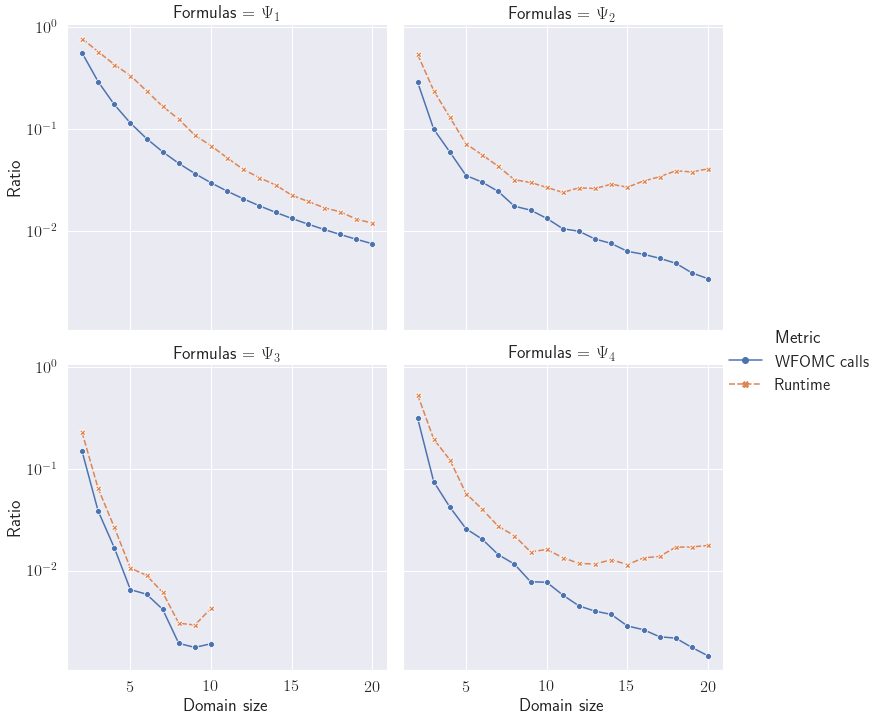

In [20]:
# g = sns.relplot(x="Domain size", y="Fast", hue="Formulas", style='Metric',
#             dashes=True, markers=True, kind="line", data=data)
# g.fig.get_axes()[0].set_yscale('log')
# g = sns.relplot(x="Domain size", y="DFT", hue="Formulas", style='Metric',
#             dashes=True, markers=True, kind="line", data=data[data['Metric'] == 'runtime'])
# g.fig.get_axes()[0].set_yscale('log')

g = sns.relplot(x="Domain size", y="Ratio", hue="Metric", style='Metric',
                dashes=True, markers=True, kind="line", col='Formulas', col_wrap=2, 
                data=data[(data['Metric'] == 'WFOMC calls') | (data['Metric'] == 'Runtime')], legend='brief')

g.fig.get_axes()[0].set_yscale('log')
# leg = g._legend
# leg.set_bbox_to_anchor([1.1, 0.5])  # coordinates of lower left of bounding box
fig = plt.gcf()
# fig.set_size_inches(8, 9)
fig.savefig('./fast_rmp_comparision.pdf')

# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
# ax1.set_ylabel('Runtime improvement ratio')
# ax1.axvline(linestyle='--')
# ax2.set_ylabel('Oracle calls improvement ratio')
# ax2.axvline(9)

# iter_wfomc_num, dft_wfomc_num, iter_time, dft_time = \
#     parse_file('./logs/ex1/iter/', './logs/ex1/dft', max_domain_size=10)
# improvement_runtime = [math.log(iter_t / dft_t) for iter_t, dft_t in zip(iter_time, dft_time)]
# improvement_wfomc = [math.log(iter_n / dft_n) for iter_n, dft_n in zip(iter_wfomc_num, dft_wfomc_num)]
# ax1.plot(improvement_runtime, label=r'$\Psi_2$, runtime', color='r')
# ax2.plot(improvement_wfomc, label=r'$\Psi_2$, oracle calls', color='r', linestyle='--')
# iter_wfomc_num, dft_wfomc_num, iter_time, dft_time = \
#     parse_file('./logs/ex2/iter/', './logs/ex2/dft', max_domain_size=10)
# improvement_runtime = [math.log(iter_t / dft_t) for iter_t, dft_t in zip(iter_time, dft_time)]
# improvement_wfomc = [math.log(iter_n / dft_n) for iter_n, dft_n in zip(iter_wfomc_num, dft_wfomc_num)]
# ax1.plot(improvement_runtime, label=r'$\Psi_3$, runtime', color='b',)
# ax2.plot(improvement_wfomc, label=r'$\Psi_3$, oracle calls', color='b', linestyle='--')
    
# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# plt.legend(lines + lines2, labels + labels2, loc=0)

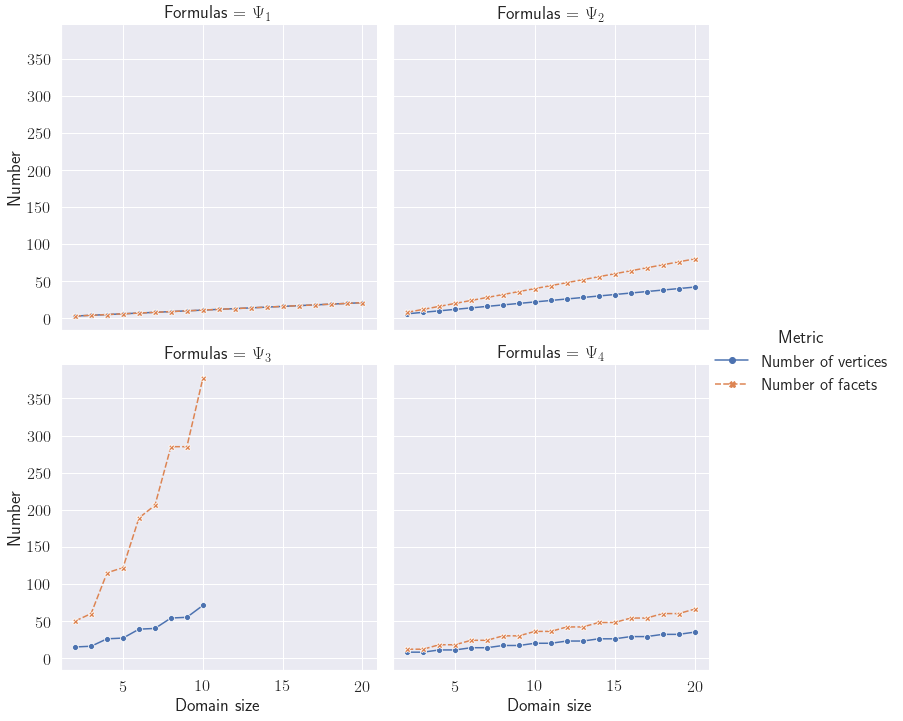

In [22]:
g = sns.relplot(x="Domain size", y="Fast", hue="Metric", style='Metric',
                dashes=True, markers=True, kind="line", col='Formulas', col_wrap=2, 
                data=data[(data['Metric'] == 'Number of vertices') | (data['Metric'] == 'Number of facets')], 
                legend='brief')

g.set_axis_labels("Domain size", "Number")
# g.fig.get_axes()[0].set_yscale('log')
# leg = g._legend
# leg.set_bbox_to_anchor([1.1, 0.5])  # coordinates of lower left of bounding box
fig = plt.gcf()
# fig.set_size_inches(8, 9)
fig.savefig('./fast_rmp_convex_hull_stat.pdf')

In [ ]:
import pickle

def read_vertices(file_name):
    with open(file_name, 'rb') as f:
        convex_hull = pickle.load(f)
    return set([str(convex_hull.points[v]) for v in convex_hull.vertices])
    

def check(iter_dir, dft_dir, max_domain_size=50):
    for i in range(2, max_domain_size + 1):
        iter_vertices = read_vertices('{}/{}/convex_hull.pkl'.format(iter_dir, i))
        dft_vertices = read_vertices('{}/{}/convex_hull.pkl'.format(dft_dir, i))
        if iter_vertices != dft_vertices:
            print("mismatched convex hull when domain size is {}".format(i))
            print("iter vertices: {}".format(sorted(iter_vertices)))
            print("dft vertices: {}".format(sorted(dft_vertices)))
    print('all matched!')
    

check('./logs/ex2/iter/', 'logs/ex2/dft/', 50)

In [7]:
###### from glob import glob

def parse_log(prefix):
    files = glob('{}*'.format(prefix))
#     files = ['{}_{}.log'.format(prefix, i) for i in range(10)]
    n_MCs = []
    n_non_MCs = []
    runtimes = []
    linprog_time = []
    for f in files:
        with open(f, 'r') as f:
            log_str = f.read()
            if re.findall(r'Total number of model counter calls: (\d+)', log_str):
                n_MC = float(re.findall(r'Total number of model counter calls: (\d+)', log_str)[0])
                n_non_MC = float(re.findall(r'Number of non-heuristic model counter calls so far: (\d+)', 
                                            log_str)[0])
                runtime = float(re.findall(r'Runtime: ([\d\.]+)', log_str)[0])
                linprog = re.findall(
                    r'elapsed time for calculating upper and lower bound: ([\d\.]+)',log_str
                )
                if linprog:
                    linprog_time = np.sum(list(map(float, linprog)))
                n_MCs.append(n_MC)
                n_non_MCs.append(n_non_MC)
                runtimes.append(runtime)
    return n_MCs, n_non_MCs, runtimes, linprog_time

max_domain_size = 6
data = []
for i in range(2, max_domain_size+1):
    n_MC, n_non_MC, runtime, _ = parse_log(
        './approxWFOMC/logs/smokes_drinks/weight_normal/mln/origin/domain_{}'.format(i)
    )
    for n1, n2, t in zip(n_MC, n_non_MC, runtime):
        data.append([r'$\Phi_2$', 'ApproxWFOMC', i, n1, n2, t, 0])
    n_MC, n_non_MC, runtime, linprog_time = parse_log(
        './approxWFOMC/logs/smokes_drinks/weight_normal/mln/improve/domain_{}'.format(i)
    )
    for n1, n2, t in zip(n_MC, n_non_MC, runtime):
        data.append([r'$\Phi_2$', 'Fast-approxWFOMC', i, n1, n2, t, linprog_time])

# data = pd.DataFrame(data, columns=['MLN', 'algo', 'domain size', 
#                                    'MC calls', 'non heuristic MC calls', 'runtime'])
# g = sns.catplot(x='domain size', y='runtime', hue='algo', kind="point", data=data)
# g.fig.get_axes()[0].set_yscale('log')

In [8]:
max_domain_size = 6
# data = []
for i in range(2, max_domain_size+1):
    n_MC, n_non_MC, runtime, _ = parse_log(
        './approxWFOMC/logs/disease/weight_normal/origin/domain_{}'.format(i)
    )
    for n1, n2, t in zip(n_MC, n_non_MC, runtime):
        data.append([r'$\Phi_3$', 'ApproxWFOMC', i, n1, n2, t, 0])
    n_MC, n_non_MC, runtime, linprog_time = parse_log(
        './approxWFOMC/logs/disease/weight_normal/improve/domain_{}'.format(i)
    )
    for n1, n2, t in zip(n_MC, n_non_MC, runtime):
        data.append([r'$\Phi_3$', 'Fast-approxWFOMC', i, n1, n2, t, linprog_time])

In [9]:
max_domain_size = 10
# data = []
for i in range(2, max_domain_size+1):
    n_MC, n_non_MC, runtime, _ = parse_log(
        './approxWFOMC/logs/smokes_drinks/evidence/origin/domain_{}'.format(i)
    )
    for n1, n2, t in zip(n_MC, n_non_MC, runtime):
        data.append([r'$\Phi_1$', 'ApproxWFOMC', i, n1, n2, t, 0])
    n_MC, n_non_MC, runtime, linprog_time = parse_log(
        './approxWFOMC/logs/smokes_drinks/evidence/improve/domain_{}'.format(i)
    )
    for n1, n2, t in zip(n_MC, n_non_MC, runtime):
        data.append([r'$\Phi_1$', 'Fast-approxWFOMC', i, n1, n2, t, linprog_time])

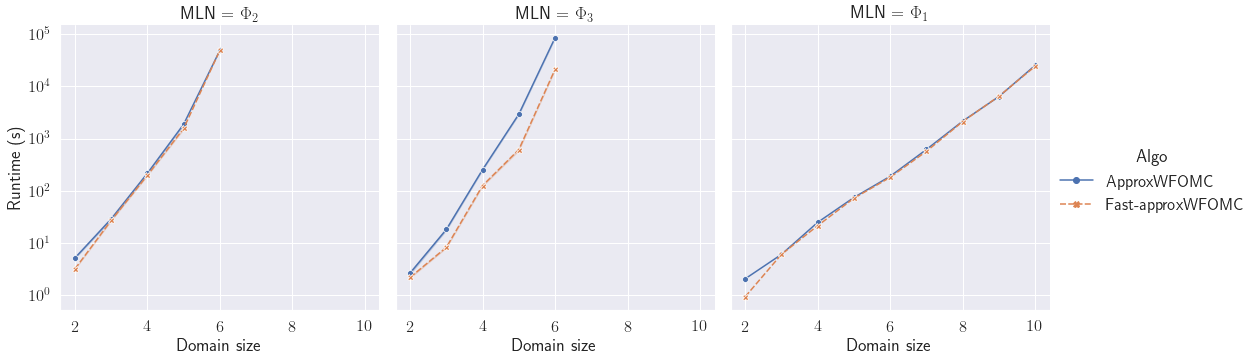

In [11]:
dataframe = pd.DataFrame(data, columns=['MLN', 'Algo', 'Domain size', 'MC calls', 
                                   'non heuristic MC calls', 'Runtime (s)', 'linprog time (s)'])
g = sns.relplot(x='Domain size', y='Runtime (s)', hue='Algo', style='Algo', legend='full',
                 dashes=True, markers=True, kind='line', col='MLN', 
                data=dataframe) #[dataframe['MLN'] == r'$\Phi_1$'])
g.fig.get_axes()[0].set_yscale('log')
# ax2 = plt.twinx()
# g = sns.lineplot(x='Domain size', y='non heuristic MC calls', hue='Method', style='Method', legend='full',
#              dashes=False, markers=True, 
#              data=dataframe[dataframe['MLN'] == r'$\Phi_1$'], ax=ax2)
# g.lines[0].set_linestyle("--")
# g.lines[1].set_linestyle("--")
# g.set_yticks([0, 1000, 2000, 3000, 4000, 5000, 25000])

# fig = plt.gcf()
# fig.set_size_inches(12, 5)
fig = g.fig
fig.savefig('./fast_approxwfomc_comparison.pdf')

In [ ]:
def detail_runtime(file_name):
    runtimes = []
    cnt = 0
    with open(file_name) as f:
        lines = f.readlines()
    for i in range(len(lines)):
        start = re.findall(r'\[\w ([\d\:\ ]+) approxwfomc\:\d+\] Delta value', lines[i])
        if start:
            start = parse_date(start[0])
            if i < len(lines) - 1:
                end = re.findall(r'\[\w ([\d\:\ ]+) approxwfomc', lines[i+1])
                end = parse_date(end[0])
                runtimes.append([cnt, (end - start).seconds])
                cnt += 1
                
    return runtimes
            

runtimes = []
origin_runtimes = detail_runtime('./approxWFOMC/logs/smokes_drinks/weight_normal/mln/origin/domain_6_1.log')
for i in origin_runtimes:
    runtimes.append(['ApproxWFOMC'] + i)
improve_runtimes = detail_runtime('./approxWFOMC/logs/smokes_drinks/weight_normal/mln/improve/domain_6_1.log')
for i in improve_runtimes:
    runtimes.append(['Fast-ApproxWFOMC'] + i)
    
runtimes = pd.DataFrame(runtimes, columns=['Algo', 'Calls', 'Runtime'])
print(runtimes[runtimes['Algo'] == 'Fast-ApproxWFOMC'].mean())
sns.lineplot(x='Calls', y='Runtime', hue='Algo', data=runtimes)

In [ ]:
def parse_bound_converge(prefix):
    data = []
    
    files = glob('{}*'.format(prefix))
    for file_name in files:
        with open(file_name, 'r') as f:
            lines = f.readlines()
        n_calls = 0
        for l in lines:
            res = re.findall(r'Delta value for approxmc call (\d+) is', l)
            if res:
                n_calls = int(res[0])
            res = re.findall(r'Current bounds on WMC: \[([\d\.e\+]+), ([\d\.e\+]+)\]', l)
            if res:
                data.append([n_calls, float(res[0][0]), float(res[0][1])])
    return data
       
data = []
raw = parse_bound_converge('./approxWFOMC/logs/smokes_drinks/evidence/origin/domain_10')
for n, lower, upper in raw:
    data.append([n, lower, 'lower bound', 'ApproxWFOMC'])
    data.append([n, upper, 'upper bound', 'ApproxWFOMC'])
raw = parse_bound_converge('./approxWFOMC/logs/smokes_drinks/evidence/improve/domain_10')
for n, lower, upper in raw:
    data.append([n, lower, 'lower bound', 'Fast-approxWFOMC'])
    data.append([n, upper, 'upper bound', 'Fast-approxWFOMC'])
#     data.append([n, 6.75e33, 'upper bound', 'Oracle'])
#     data.append([n, 6.75e33, 'upper bound', 'Oracle'])
    
pd_data = pd.DataFrame(data, columns=['Number of calls', 'Bound', 'Type', 'Algo'])
g = sns.lineplot(x='Number of calls', y='Bound', hue='Algo', style='Algo', legend=False, # markers=True,
                 data=pd_data[pd_data['Type'] == 'lower bound'][pd_data['Number of calls'] >= 0][pd_data['Number of calls'] <= 200])
g = sns.lineplot(x='Number of calls', y='Bound', hue='Algo', style='Algo', # markers=True, 
                 legend=True, data=pd_data[pd_data['Type'] == 'upper bound'][pd_data['Number of calls'] >= 0][pd_data['Number of calls'] <= 200])
g.set_yscale('log')

fig = plt.gcf()
fig.set_size_inches(6, 5)
fig = g.get_figure()
fig.savefig('./bound_converge.pdf')

In [ ]:
class Faces():
    def __init__(self, tri, sig_dig=12, method="convexhull"):
        self.method = method
        self.tri = np.around(np.array(tri), sig_dig)
        self.grpinx = list(range(len(tri)))
        norms = np.around([self.norm(s) for s in self.tri], sig_dig)
        _, self.inv = np.unique(norms, return_inverse=True, axis=0)

    def norm(self, sq):
        cr = np.cross(sq[2] - sq[0], sq[1] - sq[0])
        return np.abs(cr / np.linalg.norm(cr))

    def isneighbor(self, tr1, tr2):
        a = np.concatenate((tr1, tr2), axis=0)
        return len(a) == len(np.unique(a, axis=0)) + 2

    def order(self, v):
        if len(v) <= 3:
            return v
        v = np.unique(v, axis=0)
        n = self.norm(v[:3])
        y = np.cross(n, v[1] - v[0])
        y = y / np.linalg.norm(y)
        c = np.dot(v, np.c_[v[1] - v[0], y])
        if self.method == "convexhull":
            h = ConvexHull(c)
            return v[h.vertices]
        else:
            mean = np.mean(c, axis=0)
            d = c - mean
            s = np.arctan2(d[:, 0], d[:, 1])
            return v[np.argsort(s)]

    def simplify(self):
        for i, tri1 in enumerate(self.tri):
            for j, tri2 in enumerate(self.tri):
                if self.isneighbor(tri1, tri2) and \
                        self.inv[i] == self.inv[j]:
                    self.grpinx[j] = self.grpinx[i]
        groups = []
        print(self.grpinx)
        for i in np.unique(self.grpinx):
            u = self.tri[self.grpinx == i]
            u = np.concatenate([d for d in u])
            u = self.order(u)
            groups.append(u)
        return groups


def plot_convex_hull(convex_hull, file_name=None):
    dimension = convex_hull.points.shape[1]
    if dimension > 3:
        logger.warning('Cannot show convex hull in 4D space')
        return

    ax = a3.Axes3D(plt.figure())
    org_triangles = [convex_hull.points[s] for s in convex_hull.simplices]
    f = Faces(org_triangles)
    g = f.simplify()

    colors = sns.color_palette('tab10', n_colors=len(g))
    pc = a3.art3d.Poly3DCollection(g, facecolor=colors, edgecolor='k', alpha=0.8)
    ax.add_collection3d(pc)
    ax.dist = 10
    ax.azim = 30
    ax.elev = 10
    ax.set_xlim([convex_hull.min_bound[0], convex_hull.max_bound[0]])
    ax.set_ylim([convex_hull.min_bound[1], convex_hull.max_bound[1]])
    
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_zlim([convex_hull.min_bound[2], convex_hull.max_bound[2]])
    ax.set_xlabel(r'$N(\alpha_1, \omega)$')
    ax.set_ylabel(r'$N(\alpha_2, \omega)$')
    ax.set_zlabel(r'$N(\alpha_3, \omega)$')


with open('./check-points/convex_hull.pkl', 'rb') as f:
    convex_hull = pickle.load(f)
    
plot_convex_hull(convex_hull)
    
bounding_box = [[0, 49, 0], [0, 49, 7], [0, 0, 0], [0, 0, 7], [7, 49, 0], [7, 49, 7], [7, 0, 0], [7, 0, 7]]
convex_hull = ConvexHull(bounding_box)
# plot_convex_hull(convex_hull)
plt.savefig('./check-points/convex_hull.pdf')

In [ ]:
c = sns.color_palette(n_colors=1)
sns.set_theme()

with open('./check-points/convex_hull.pkl', 'rb') as f:
    hull = pickle.load(f)
    
for s in hull.simplices:
    plt.plot(*hull.points[s, :].T, '-', color=c[0], lw=2)


plt.plot(hull.points[hull.vertices, 0], hull.points[hull.vertices, 1], 'o', color=c[0])
plt.fill(hull.points[hull.vertices,0], hull.points[hull.vertices,1], color=c[0], alpha=0.3)
plt.xlabel(r'$N(\alpha_1, \omega)$')
plt.ylabel(r'$N(\alpha_2, \omega)$')


# fig = plt.gcf()
# fig.set_size_inches(6, 4)
plt.ylim(0, 9)
plt.savefig('./check-points/convex_hull.pdf')

In [ ]:
dist = np.load('./check-points/fr_sm/dist.npy')
dist[np.where(np.abs(dist) < 1e-15)] = 0
dist_log = np.log10(dist)
dist_log[np.isinf(dist_log)] = dist_log[np.isfinite(dist_log)].min() - 1
ax = sns.heatmap(dist_log.T)
ax.invert_yaxis()

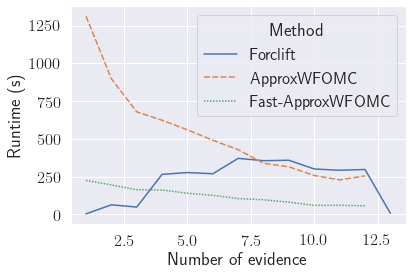

In [102]:
runtimes = []

for i in range(14):
    f_name = '../Forclift/logs/fr_sm_dr2//{}.log'.format(i)
    if os.path.exists(f_name):
        with open(f_name, 'r') as f:
            res = re.findall(r'Inference took (\d+) ms', f.read())
            if res:
                runtimes.append([i, 'Forclift', int(res[0]) / 1000])
    f_name = 'approxWFOMC/logs/smokes_drinks2//evidence/origin/{}.log'.format(i)
    if os.path.exists(f_name):
        with open(f_name, 'r') as f:
            res = re.findall(r'Runtime: ([\d\.]+)', f.read())
            if res:
                runtimes.append([i, 'ApproxWFOMC', float(res[0])])
    f_name = 'approxWFOMC/logs/smokes_drinks2//evidence/improve/{}.log'.format(i)
    if os.path.exists(f_name):
        with open(f_name, 'r') as f:
            res = re.findall(r'Runtime: ([\d\.]+)', f.read())
            if res:
                runtimes.append([i, 'Fast-ApproxWFOMC', float(res[0])])
            
runtimes = pd.DataFrame(runtimes, columns=['Number of evidence', 'Method', 'Runtime (s)'])
sns.lineplot(x='Number of evidence', y='Runtime (s)', hue='Method', style='Method', data=runtimes)